# House Prices-Advanced Regression Techniques (1st attempt)

![](photo1.png)

**Goal: predict the sales price for each house**

In [33]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
from scipy.stats import norm, skew
from scipy import stats
from scipy.special import boxcox1p
fff

In [34]:
## Import train and test csv as dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [35]:
train.shape

(1460, 81)

In [36]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Features engineering

In [37]:
#check the shape of data and features
print("The original train data size (before dropping Id feature is) : {} ".format(train.shape))

The original train data size (before dropping Id feature is) : (1460, 81) 


In [38]:
train.columns
# train.index

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [1]:
# save y values
y_train = train.SalePrice.values
# y_train = train['SalePrice'].values

NameError: name 'train' is not defined

### Target Variable

Our target variable is a 'SalePrice'. So let's do some analysis on this variable first.

In [40]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

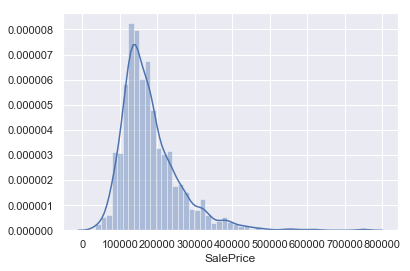

In [41]:
#histogram
sns.distplot(train['SalePrice']);

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

**WHY do we use log to transform the data?**



 mu = 12.02 and sigma = 0.40



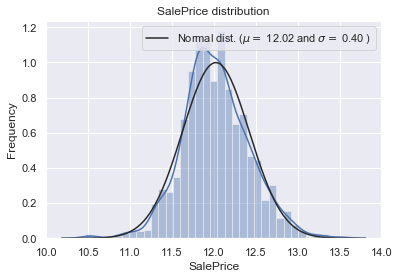

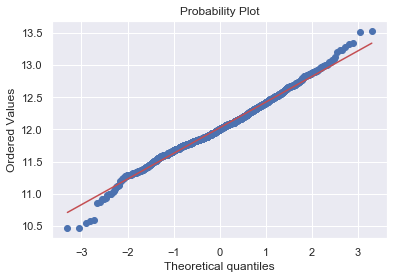

In [42]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Relationships between variables

Before we analyze the relationships between SalePrice and variables, let's take a look at our variables.
Is there a missing value?

**Delete Missing Data**

In [43]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

In [44]:
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


- **Lot Frontage:** In this case, missing data doesn't mean that the property doesn't have a LotFrontage. Since the area of each street connected to the house property, most likely it has a similar area to other houses in its neighborhood. Therefore, we can fill in missing values by the median LotFrontage of the neighborhood

In [45]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Adding total sqfootage feature 
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

In [46]:
cols = list((missing_data[missing_data['Percent'] <= 0.9]).index)
train = train[cols].copy()
print(train.isnull().sum().max())

0


In [47]:
# cols = ['RoofMatl', 'Exterior1st', 'RoofStyle', 'ExterQual',
#         'Exterior2nd', 'YearBuilt', 'ExterCond', 'Foundation',
#         'YearRemodAdd', 'SalePrice', 'OverallCond', 'OverallQual',
#         'HouseStyle', 'BldgType', 'Condition2', 'Condition1', 
#         'Neighborhood', 'LandSlope', 'LotConfig', 'Utilities', 
#         'LandContour', 'LotShape', 'Street', 'LotArea', 'MSZoning', 
#         'BsmtFinSF1', 'HeatingQC', 'BsmtFinSF2', 'EnclosedPorch', 
#         'Fireplaces', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 
#         'OpenPorchSF', '3SsnPorch', 'BsmtUnfSF', 'ScreenPorch', 'PoolArea', 
#         'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'Functional', 'TotRmsAbvGrd',
#         'KitchenQual', 'KitchenAbvGr', 'BedroomAbvGr', 'HalfBath', 'FullBath', 
#         'BsmtHalfBath', 'BsmtFullBath', 'GrLivArea', 'LowQualFinSF', '2ndFlrSF', 
#         '1stFlrSF', 'CentralAir', 'SaleCondition', 'Heating', 'TotalBsmtSF', 'MSSubClass']


In [48]:
# # dealing with missing data
# train = train.drop((missing_data[missing_data['Percent'] > 0.9]).index,axis = 1)
# # train.loc[:,(missing_data[missing_data['Total'] <= 0.9]).index]
# train.isnull().sum().max() #Checking that there's no missing data missing

In [49]:
y_train = train['SalePrice']

**Correlation between variables**

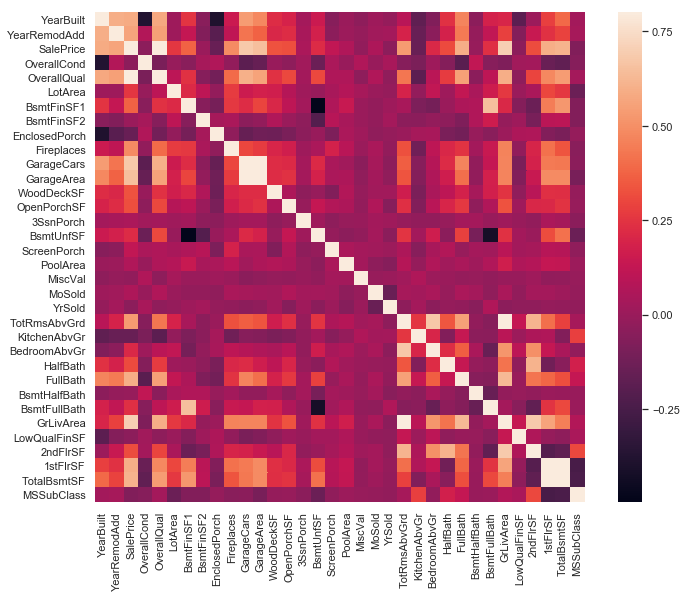

In [50]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Seems like variables (OverallQual, GrLivArea, 1stFlrSF, 2ndFlrSF, GarageCars, GarageCars, GarageArea) have high corelations with SalePrice.

GrLivArea: Above grade (ground) living area square feet, OverallQual: Overall material and finish quality

### Data Cleaning

**Outliers**

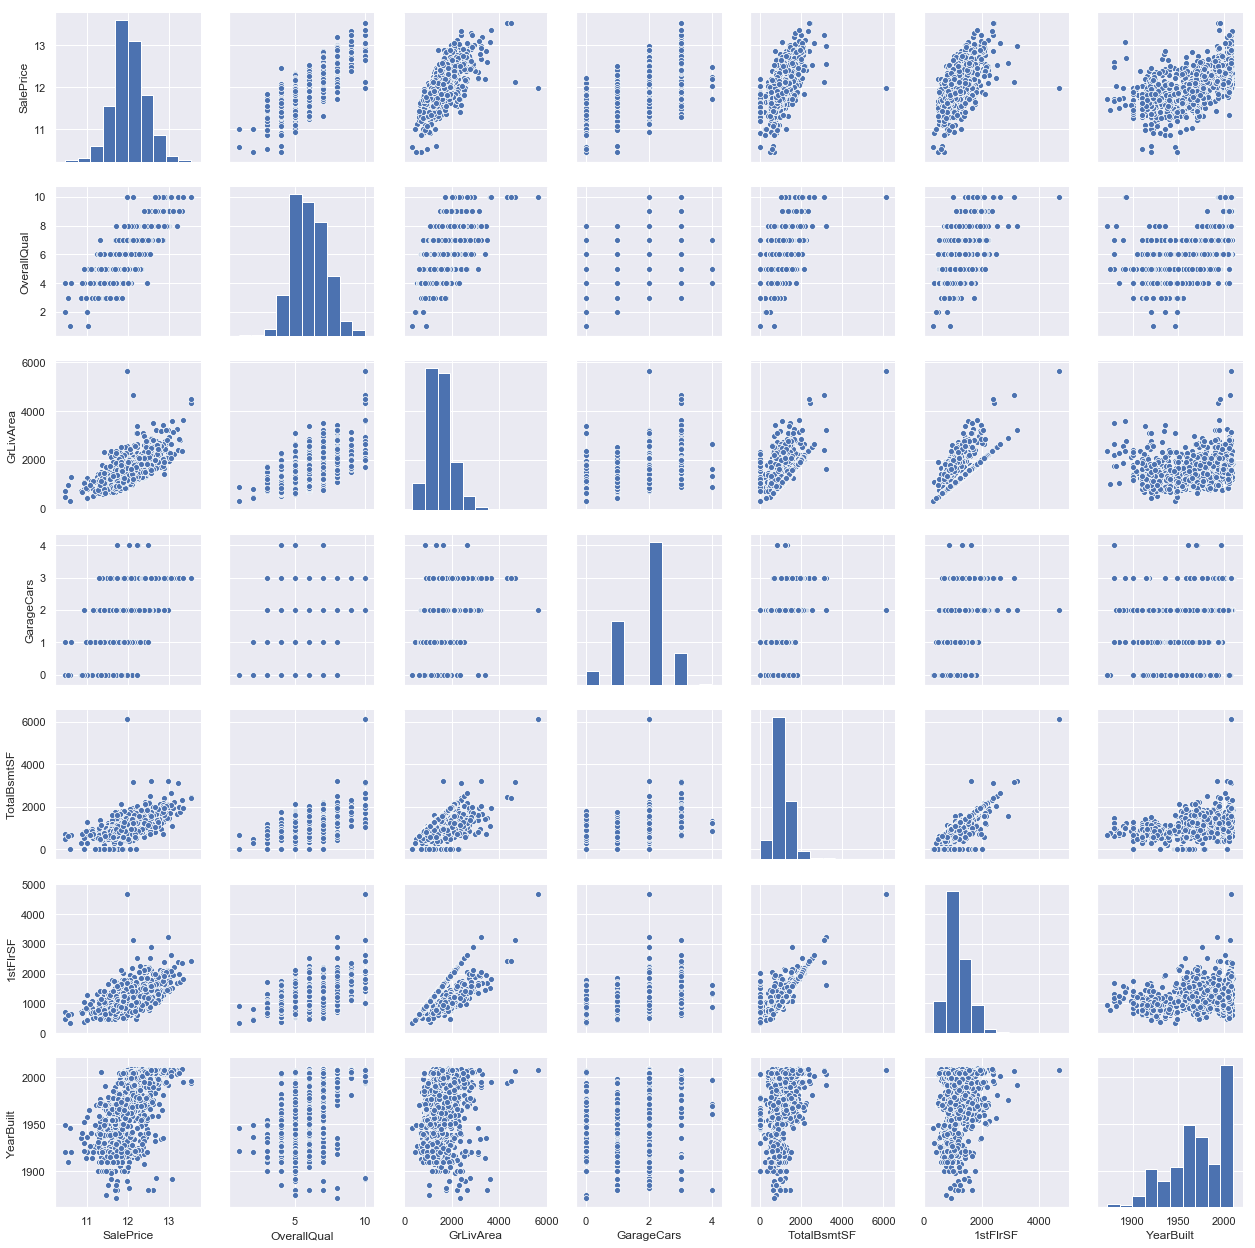

In [51]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']
sns.pairplot(train[cols], height = 2.5)
plt.show();

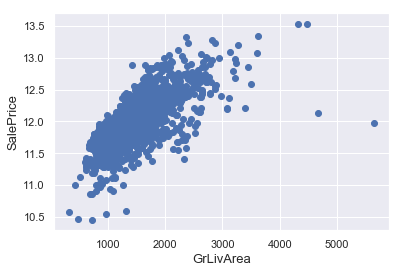

In [52]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We decided to delete these two outliers because they are very huge and really bad.

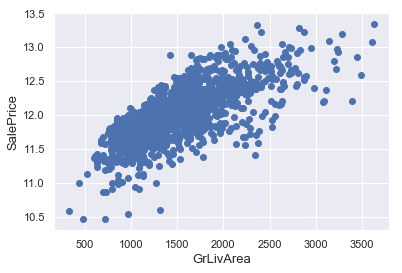

In [53]:
#Deleting outliers
condition1 = train['GrLivArea']>4000
condition2 = train['SalePrice']<200000

train = train.drop(train[condition1 & condition2].index)

# train.index = range(len(train))
# train = train.loc[~(condition1 & condition2),:].copy()

# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

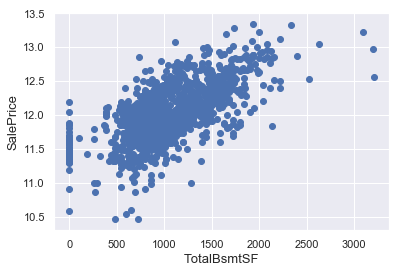

In [54]:
#Deleting outliers
# 위 처럼 읽기 좋게 코드를 작성하면 좋음.

train = train.drop(train[(train['TotalBsmtSF'] > 4000) & (train['TotalBsmtSF']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['TotalBsmtSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

In [55]:
y_train = train['SalePrice']

### Skewness

In [56]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

In [57]:
numeric_feats

Index(['YearBuilt', 'YearRemodAdd', 'SalePrice', 'OverallCond', 'OverallQual',
       'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'EnclosedPorch', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch',
       'BsmtUnfSF', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'TotRmsAbvGrd', 'KitchenAbvGr', 'BedroomAbvGr', 'HalfBath', 'FullBath',
       'BsmtHalfBath', 'BsmtFullBath', 'GrLivArea', 'LowQualFinSF', '2ndFlrSF',
       '1stFlrSF', 'TotalBsmtSF', 'MSSubClass'],
      dtype='object')

In [58]:
# Check the skew of all numerical features
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.418175
PoolArea,17.504556
LotArea,12.574590
3SsnPorch,10.279262
LowQualFinSF,8.989291
KitchenAbvGr,4.476748
BsmtFinSF2,4.244209
BsmtHalfBath,4.124712
ScreenPorch,4.111400
EnclosedPorch,3.081275


In [59]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

There are 34 skewed numerical features to Box Cox transform


In [60]:
train = pd.get_dummies(train)
print(train.shape)

(1456, 215)


In [ ]:
train

### Modelling

In [62]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb

In [30]:
#!pip install xgboost

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = cv))
    return(rmse)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
len(y_train)

**Kernel Ridge Regression**

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
#train.iloc[1:3,1:3]

In [ ]:
#train.loc[1:3,['LotArea','Street']]

In [ ]:
# train.loc[]
# train.iloc[]
# train[keys]
# train[key].apply()

**Reference**

- [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by Serigne